20210706：主要将每个格点的npz文件整理成tif

In [8]:
import os
import glob
import imageio
import logging
import shapefile
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from numpy import meshgrid
from numpy import linspace
from matplotlib import gridspec
from IPython.display import Image
from osgeo import gdal, osr
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import PathPatch
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [3]:
year=2015

## 单点结果示意

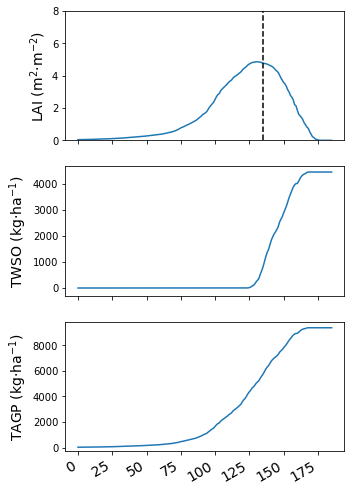

In [4]:
files=glob.glob("D:\hh\@进行中的工作\ESSD_Wheat_Multi-vars\结果\V2-3/%d/2513_*_V2-3.npz"%year)
file=files[20]
re=np.load(file)
lai,twso,tagp,dvs,s_doy=re['lai'],re['twso'],re['tagp'],re['dvs'],re['doy']
fig, ax = plt.subplots(3,1,figsize=(5,9),sharex=True)
ax[0].plot(range(len(lai)),lai)
for i in range(len(dvs)):
    if abs(dvs[i]-1)<0.01:
        ax[0].axvline(x=i,ls="--",c="k")#添加垂直直线
ax[1].plot(range(len(twso)),twso)
ax[2].plot(range(len(tagp)),tagp)

plt.xticks(fontsize=14)

ax[0].set_ylabel('LAI ('+'$ \mathrm{m}^{2}$'+'$\cdot$'+'$\mathrm{m}^{-2}$'+')',fontsize=14)
ax[1].set_ylabel('TWSO ('+'$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'+')',fontsize=14)
ax[2].set_ylabel('TAGP ('+'$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'+')',fontsize=14)
ax[0].set_ylim(0,8)

ax[1].set_ylim(-300,np.nanmax(twso)*1.05)
ax[2].set_ylim(-300,np.nanmax(tagp)*1.05)
fig.autofmt_xdate()# 日期的排列根据图像的大小自适应
# fig.savefig('D:/a进行中工作/ESSD_AGB_2021_不备份/png/单点动态/%03d.jpg'%(d),dpi=80,bbox_inches='tight')


此处引发的一个问题就是由于修改了开始生成籽粒产量的起始DVS，会导致开花和LAI峰值不吻合

In [23]:
s_doy+0

291

## 变量整理为单个表格
需要整理的变量：逐日LAI、TWSO、TAGP，最大LAI，TWSO，TAGP

时间：前一年10月初-当年6月底(简化为doy-90☞doy180)

In [25]:
days=datetime.date(year-1,12,31).timetuple().tm_yday#前一年天数
dir_=Path('D:\hh\@进行中的工作\ESSD_Wheat_Multi-vars\结果\V2-3\数据整理/%d'%year)
dir_.mkdir(parents=True, exist_ok=True)

CreatVar=locals()
for doy in np.arange(-90,181,1):
    if doy==0:
        continue
    CreatVar['lst_%d'%doy]=[]
lst_max=[]
files=glob.glob("D:\hh\@进行中的工作\ESSD_Wheat_Multi-vars\结果\V2-3/%d/*_*_V2-3.npz"%year)
ii=0
for file in files:
    ii+=1
    if ii%10000==0:
        print('%d/%d'%(i,len(files)))
    re=np.load(file)
    lai,twso,tagp,dvs,s_doy=re['lai'],re['twso'],re['tagp'],re['dvs'],re['doy']
    lai_max,twso_max,tagp_max=np.nanmax(lai),np.nanmax(twso),np.nanmax(tagp)
    for i in range(len(dvs)):
        if abs(dvs[i]-1)<0.01:
            flw=s_doy+i-days
        mat=0
        if abs(dvs[i]-2)<0.01:
            mat=s_doy+i-days
    if mat==0:
        mat=s_doy+i-days
          
    try:
        x,y=list(map(int,file.split('/')[-1].split('_')[:2]))
    except:
        x,y=list(map(int,file.split('\\')[-1].split('_')[:2]))
        
    lst_max.append([x,y,lai_max,twso_max,tagp_max,s_doy,flw,mat])
    
    doys0=[s_doy-days-1+d for d in range(len(lai))]
    doys=[]
    for d in doys0:
        if d<0:
            doys.append(d)
        else:
            doys.append(d+1)
    n=0
    for doy in doys:
        if doy<-90 or doy>180:
            continue
        v1,v2,v3=lai[n],twso[n],tagp[n]
        v1=v1 if v1==v1 else 0
        v2=v2 if v2==v2 else 0
        v3=v3 if v3==v3 else 0
        v1,v2,v3=round(v1*100)/100.,round(v2),round(v3)
        CreatVar['lst_%d'%doy].append([x,y,v1,v2,v3])
        n+=1
df_max=pd.DataFrame(columns=['x','y','LAI','TWSO','TAGP','EM',"FLW","MAT"],data=lst_max)
df_max.to_csv(dir_/'data_max_and_DVS.csv',index=False)
for doy in np.arange(-90,181,1):
    if doy==0:
        continue
    CreatVar['df_%d'%doy]=pd.DataFrame(columns=['x','y','LAI','TWSO','TAGP'],data=CreatVar['lst_%d'%doy])
    CreatVar['df_%d'%doy].to_csv(dir_/('data_%d.csv'%doy),index=False)
    
    

## 变量整理并行版  
     没写完？？实际在李老师服务器上单线程运行

In [28]:
# %%writefile data_procrssing.py

import glob
import numpy as np
import pandas as pd

CreatVar=locals()

def sayHi(file):
    re=np.load(file)
    lai,twso,tagp,dvs,s_doy=re['lai'],re['twso'],re['tagp'],re['dvs'],re['doy']*1
    lai_max,twso_max,tagp_max=np.nanmax(lai),np.nanmax(twso),np.nanmax(tagp)
    for i in range(len(dvs)):
        if abs(dvs[i]-1)<0.01:
            flw=s_doy+i-days
        mat=0
        if abs(dvs[i]-2)<0.01:
            mat=s_doy+i-days
    if mat==0:
        mat=s_doy+i-days
          
    try:
        x,y=list(map(int,file.split('/')[-1].split('_')[:2]))
    except:
        x,y=list(map(int,file.split('\\')[-1].split('_')[:2]))
        
    lst_max_and_dvs=[x,y,lai_max,twso_max,tagp_max,s_doy,flw,mat]
    
    doys0=[s_doy-days-1+d for d in range(len(lai))]
    doys=[]
    for d in doys0:
        if d<0:
            doys.append(d)
        else:
            doys.append(d+1)
    n=0
    lst_data=[]
    for doy in doys:
        if doy<-90 or doy>180:
            continue
        v1,v2,v3=lai[n],twso[n],tagp[n]
        v1=v1 if v1==v1 else 0
        v2=v2 if v2==v2 else 0
        v3=v3 if v3==v3 else 0
        v1,v2,v3=round(v1*100)/100.,round(v2),round(v3)
        lst_data.append([x,y,v1,v2,v3])
        n+=1    
    return [doys,lst_data,lst_max_and_dvs]

def mycallback(x):
    # print(x)
    try:
        csv_write.writerow(x)
    except:
        pass



year=2008
files=glob.glob("D:\hh\@进行中的工作\ESSD_Wheat_Multi-vars\结果\V2-3/%d/*_*_V2-3.npz"%year)
# sayHi(files[0])

## 批量生成tif

LAI


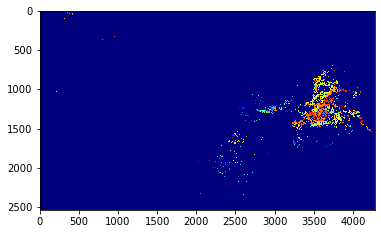

TWSO


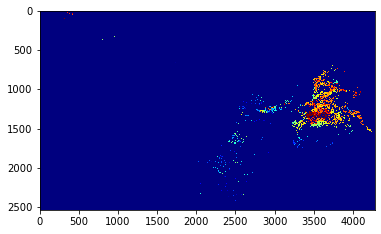

TAGP


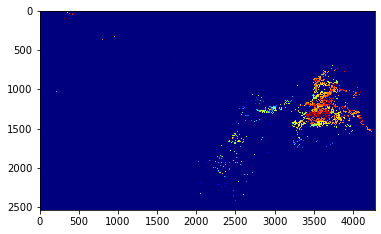

EM


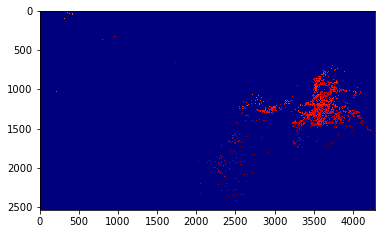

FLW


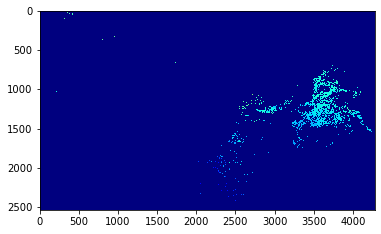

MAT


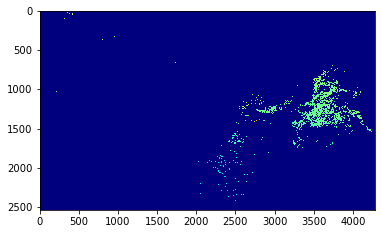

LAI_2008
..............................................................................................................................................................................................................................................................................TWSO_2008
..............................................................................................................................................................................................................................................................................TAGP_2008
...................................................................................................................

In [ ]:
ds=gdal.Open('D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/MOD_LAI_2000-2015/BNU_LAI/masked_tif/BNU_MODIS_LAI_%d.tif'%year)
gt=ds.GetGeoTransform() #分辨率严格为0.01°
rows=ds.RasterYSize
cols=ds.RasterXSize

Path('D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d'%year).mkdir(parents=True, exist_ok=True)

#MAX LAI， TWSO， TAGP and DVS
for item in ['LAI','TWSO','TAGP','EM',"FLW","MAT"]:
    image = np.zeros((cols, rows), int)
    print('%s'%item)
    if item in ['LAI','TWSO','TAGP']:
        file='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/%s_%d_max.tif'%(year,item,year)
    else:
        file='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/%s_%d_DOY.tif'%(year,item,year)
    for line in df_max[['x','y',item]].iloc:
        row = int(line['y'])
        col = int(line['x'])
        try:
            image[col, row] = line[item]*100 if item=='LAI' else line[item]
        except:# Nan 值
            image[col, row] = 0

    driver = gdal.GetDriverByName ( "GTiff" ) # Get a handler to a driver
    dataset_y = driver.Create ( file,cols, rows,1, gdal.GDT_Int16, options=['COMPRESS=LZW'] )
    dataset_y.SetGeoTransform ( gt)
    dataset_y.SetProjection ( ds.GetProjectionRef() )
    dataset_y.GetRasterBand(1).SetNoDataValue(0)
    dataset_y.GetRasterBand(1).WriteArray(image.transpose())
    dataset_y.FlushCache()
    del dataset_y
    if item=='LAI':
        vmin,vmax=0,800
    elif item=='TWSO':
        vmin,vmax=1000,7000
    elif item=='TAGP':
        vmin,vmax=2000,15000
    else:
        vmin,vmax=0,330
    plt.imshow(image.transpose(), interpolation='nearest', vmin=vmin, vmax=vmax, cmap=plt.cm.jet)
    plt.show()

# Daily LAI, TWSO, TAGP
for item in ['LAI','TWSO','TAGP']:
    print('%s_%d'%(item,year))
    for doy in np.arange(-90,181,1):
        if doy==0:
            continue
        print('.',end='')
        image = np.zeros((cols, rows), int)
        file='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/%s_Daily_%d%03d.tif'%(year,item,year,doy)    
        for line in CreatVar['df_%d'%doy][['x','y',item]].iloc:
            row = int(line['y'])
            col = int(line['x'])
            try:
                image[col, row] = line[item]*100 if item=='LAI' else line[item]
            except:# Nan 值
                image[col, row] = 0

        driver = gdal.GetDriverByName ( "GTiff" ) # Get a handler to a driver
        dataset_y = driver.Create ( file,cols, rows,1, gdal.GDT_Int16, options=['COMPRESS=LZW'] )
        dataset_y.SetGeoTransform ( gt)
        dataset_y.SetProjection ( ds.GetProjectionRef() )
        dataset_y.GetRasterBand(1).SetNoDataValue(0)
        dataset_y.GetRasterBand(1).WriteArray(image.transpose())
        dataset_y.FlushCache()
        del dataset_y

In [ ]:
ff

## 横版colorbar(暂时未使用)

In [3]:
logging.getLogger().setLevel(logging.INFO)
plt.rcParams['font.sans-serif'] = 'Times New Roman' # or 'SimHei'
class DAPlot:
  def __init__(self, raster_files, output_path, title, figName, bar_label, scale=1,min=None, max=None,n_color=None,imshow=True):
    self.raster_files = raster_files
    self.output_path =output_path
    self.title =title
    self.figName = figName
    self.bar_label = bar_label
    self.Pro_shp = 'D:/hh/市界-县界/省级行政区划'
    self.Nine_shp = 'D:/hh/市界-县界/中国行政区_包含南海九段线'
    self.scale = scale
    self.min = min
    self.max = max 
    self.n_color=n_color#必要时自己给定，保持刻度条整数
    self.imshow=imshow

  def plot(self):     
    shpfile = self.Pro_shp
    ds = gdal.Open(self.raster_files)
    data = ds.ReadAsArray()*self.scale
    gt = ds.GetGeoTransform()

    nx = data.shape[1]
    ny = data.shape[0]
    lons, lone = gt[0],gt[0]+gt[1]*nx 
    lats, late = gt[3],gt[3]+gt[5]*ny

    fig= plt.figure(figsize=(6.9,5))#6.9 inch 差不多是两栏，字体大小在此基础上6-12号
    ax= fig.add_subplot(111)

    map = Basemap(rsphere=(6378137.00,6356752.31414),llcrnrlon=81, llcrnrlat=15, \
        urcrnrlon=138, urcrnrlat=51.5, projection='aea',  resolution=None, \
        lat_1=25, lat_2=47, lon_0=105, ax = ax)
    m=map
    
    
    #绘制栅格 √    
    if (self.min is None) and (self.max is None):
      temp=[a for a in data.flatten() if a]
      q1,q2=int(np.percentile(temp,5)),int(np.percentile(temp,95))#自行修改分位数比例
    else:
      q1,q2=self.min,self.max
    colors = ['red','orangered',"darkorange", "gold", "#72de40", "#42971a",'#27590f']
    nodes = [0.0, 0.15, 0.3, 0.45, 0.6, 0.8, 1.0]
    cm = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

    new_data = np.ma.masked_where(data==0, data)
    extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
              gt[3] + ds.RasterYSize * gt[5], gt[3])
    x = linspace(gt[0], gt[0] + ds.RasterXSize * gt[1], ds.RasterXSize)
    y = linspace(gt[3], gt[3] + ds.RasterYSize * gt[5], ds.RasterYSize)
    xx, yy = meshgrid(x, y)
    if self.n_color is None:
        n_color=int((q2-q1)*2)+1
        if q2-q1>1000:
            n_color=int((q2-q1)/1000)+1
    else:
        n_color=self.n_color
    if (self.min is None) and (self.max is None) and (self.n_color is None):
        cs=m.contourf(xx, yy,new_data,cmap=cm,latlon=True,extend='both')
    else:
        cs=m.contourf(xx, yy,new_data,cmap=cm,levels=np.linspace(q1,q2,n_color),latlon=True,extend='both')
#     cs = map.pcolormesh(xx, yy, new_data, cmap=cm, latlon=True, shading='auto',vmin=q1,vmax=q2)#  'flat', 'nearest', 'gouraud', 'auto' 

    #绘制colorbar
    bar=plt.colorbar(cs,orientation='horizontal',fraction=0.048, pad=0.07)#fraction调整colorbar大小，pad间距
    # bar.ax.tick_params(size=0,labelsize=1,labelcolor='white')#不显示ticks和labels
    bar.ax.tick_params(size=2,labelsize=8,labelcolor='black')
    bar.ax.set_title(self.bar_label, loc='center', fontsize=8)  
    
    #标题
    plt.title(self.title, fontsize=9, y=0.88)
    # plt.title(self.title)
    
    # 比例尺 
    map.drawmapscale(89, 21, 117.5, 36, 1500, units='km',barstyle='fancy',format='%d',fontsize=8,zorder=3)

    #指北针
    offset = 0.01*(m.ymax-m.ymin)+0.01*(m.xmax-m.xmin)
    x,y=map(72,49)
    x=x+2*offset
    y=y-offset
    ax.fill([x,x+offset,x,x-offset,x],[y,y-3.5*offset,y-2.25*offset,y-3.5*offset,y],ec='k',fc='None',zorder=3)
    ax.fill([x,x+offset,x,x],[y,y-3.5*offset,y-2.25*offset,y],ec='None',fc='w',zorder=3)
    ax.fill([x,x,x-offset,x],[y,y-2.25*offset,y-3.5*offset,y],ec='None',fc='k',zorder=3)
    ax.text(x,y+0.5*offset,'N',horizontalalignment='center',fontsize=10,zorder=3)

    #绘制经纬线
    parallels = np.arange(10.,90,5.) 
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=8, zorder=1, linewidth=0.2) # 绘制纬线
    meridians = np.arange(70.,180.,10.)
    map.drawmeridians(meridians,labels=[0,0,1,0],fontsize=8, zorder=1, linewidth=0.2) # 绘制经线              
    map.readshapefile(shpfile, 'China')

    #局部小地图：九段线区域
    axins = zoomed_inset_axes(ax, 0.38, loc = 4, borderpad=0)
    axins.set_xlim(108, 122.5)
    axins.set_ylim(3, 25)

    map2 = Basemap(rsphere=(6378137.00,6356752.31414),llcrnrlon = 108, llcrnrlat = 3, urcrnrlon = 122.5, \
               urcrnrlat = 25,projection='aea',  resolution=None, lat_1=25, lat_2=47, lon_0=105, ax = axins)                       
    shpfile = self.Nine_shp              
    map2.readshapefile(shpfile, 'China')              
    mark_inset(ax, axins, loc1=2, loc2=4, fc = "none", ec = "none")

#     plt.show()
    fig.savefig(self.output_path+'/'+self.figName,dpi=600,bbox_inches='tight')
    if not self.imshow:
        plt.clf()
        plt.close()
#     logging.info('Saving figure: %s'%self.figName)
    return self.output_path+'/'+self.figName

## 纵版colorbar

In [3]:
logging.getLogger().setLevel(logging.INFO)
plt.rcParams['font.sans-serif'] = 'Times New Roman' # or 'SimHei'
class DAPlot:
  def __init__(self, raster_files, output_path, title, figName, bar_label, scale=1,min=None, max=None,n_color=None,imshow=True):
    self.raster_files = raster_files
    self.output_path =output_path
    self.title =title
    self.figName = figName
    self.bar_label = bar_label
    self.Pro_shp = 'D:/hh/市界-县界/省级行政区划'
    self.Nine_shp = 'D:/hh/市界-县界/中国行政区_包含南海九段线'
    self.scale = scale
    self.min = min
    self.max = max 
    self.n_color=n_color#必要时自己给定，保持刻度条整数
    self.imshow=imshow

  def plot(self):     
    shpfile = self.Pro_shp
    ds = gdal.Open(self.raster_files)
    data = ds.ReadAsArray()*self.scale
    gt = ds.GetGeoTransform()

    nx = data.shape[1]
    ny = data.shape[0]
    lons, lone = gt[0],gt[0]+gt[1]*nx 
    lats, late = gt[3],gt[3]+gt[5]*ny

    fig= plt.figure(figsize=(6.9,5))#6.9 inch 差不多是两栏，字体大小在此基础上6-12号
    ax= fig.add_subplot(111)

    map = Basemap(rsphere=(6378137.00,6356752.31414),llcrnrlon=81, llcrnrlat=15, \
        urcrnrlon=138, urcrnrlat=51.5, projection='aea', \
        lat_1=25, lat_2=47, lon_0=105, ax = ax)
    m=map
    
    
    #绘制栅格 √    
    if (self.min is None) and (self.max is None):
      temp=[a for a in data.flatten() if a]
      q1,q2=int(np.percentile(temp,5)),int(np.percentile(temp,95))#自行修改分位数比例
    else:
      q1,q2=self.min,self.max
    colors = ['red','orangered',"darkorange", "gold", "#72de40", "#42971a",'#27590f'][::-1]
    nodes = [0.0, 0.15, 0.3, 0.45, 0.6, 0.8, 1.0]
    cm = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

    new_data = np.ma.masked_where(data==0, data)
    extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
              gt[3] + ds.RasterYSize * gt[5], gt[3])
    x = linspace(gt[0], gt[0] + ds.RasterXSize * gt[1], ds.RasterXSize)
    y = linspace(gt[3], gt[3] + ds.RasterYSize * gt[5], ds.RasterYSize)
    xx, yy = meshgrid(x, y)
    if self.n_color is None:
        n_color=int((q2-q1)*2)+1
        if q2-q1>1000:
            n_color=int((q2-q1)/1000)+1
    else:
        n_color=self.n_color
    if (self.min is None) and (self.max is None) and (self.n_color is None):
        cs=m.contourf(xx, yy,new_data,cmap=cm,latlon=True,extend='both')
    else:
        cs=m.contourf(xx, yy,new_data,cmap=cm,levels=np.linspace(q1,q2,n_color),latlon=True,extend='both')
#     cs = map.pcolormesh(xx, yy, new_data, cmap=cm, latlon=True, shading='auto',vmin=q1,vmax=q2)#  'flat', 'nearest', 'gouraud', 'auto' 

    #绘制colorbar
    bar=plt.colorbar(cs,orientation='vertical',fraction=0.048, pad=0.01)#fraction调整colorbar大小，pad间距
    # bar.ax.tick_params(size=0,labelsize=1,labelcolor='white')#不显示ticks和labels
    bar.ax.tick_params(size=2,labelsize=8,labelcolor='black')
    bar.set_label(self.bar_label, fontsize=8)  #注意.set_label和.ax.set_title区别
    
    #标题
    plt.title(self.title, fontsize=9, y=0.88)
    # plt.title(self.title)
    
    # 比例尺 
    map.drawmapscale(89, 21, 117.5, 36, 1500, units='km',barstyle='fancy',format='%d',fontsize=8,zorder=3)

    #指北针
    offset = 0.01*(m.ymax-m.ymin)+0.01*(m.xmax-m.xmin)
    x,y=map(72,49)
    x=x+2*offset
    y=y-offset
    ax.fill([x,x+offset,x,x-offset,x],[y,y-3.5*offset,y-2.25*offset,y-3.5*offset,y],ec='k',fc='None',zorder=3)
    ax.fill([x,x+offset,x,x],[y,y-3.5*offset,y-2.25*offset,y],ec='None',fc='w',zorder=3)
    ax.fill([x,x,x-offset,x],[y,y-2.25*offset,y-3.5*offset,y],ec='None',fc='k',zorder=3)
    ax.text(x,y+0.5*offset,'N',horizontalalignment='center',fontsize=10,zorder=3)

    #绘制经纬线
    parallels = np.arange(10.,90,5.) 
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=8, zorder=1, linewidth=0.2) # 绘制纬线
    meridians = np.arange(70.,180.,5.)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8, zorder=1, linewidth=0.2) # 绘制经线              
    map.readshapefile(shpfile, 'China')

    #局部小地图：九段线区域
    axins = zoomed_inset_axes(ax, 0.38, loc = 4, borderpad=0)
    axins.set_xlim(108, 122.5)
    axins.set_ylim(3, 25)

    map2 = Basemap(rsphere=(6378137.00,6356752.31414),llcrnrlon = 108, llcrnrlat = 3, urcrnrlon = 122.5, \
               urcrnrlat = 25,projection='aea', lat_1=25, lat_2=47, lon_0=105, ax = axins)                       
    shpfile = self.Nine_shp              
    map2.readshapefile(shpfile, 'China')              
    mark_inset(ax, axins, loc1=2, loc2=4, fc = "none", ec = "none")

#     plt.show()
    fig.savefig(self.output_path+'/'+self.figName,dpi=150,bbox_inches='tight')
    if not self.imshow:
        plt.clf()
        plt.close()
#     logging.info('Saving figure: %s'%self.figName)
    return self.output_path+'/'+self.figName

## Max_value and DVS

In [14]:
#MAX LAI， TWSO， TAGP and DVS
dct={'EM':'Emergence',"FLW":'Anthesis',"MAT":'Maturity'}
labels={'LAI':'$ \mathrm{m}^{2}$'+'$\cdot$'+'$ \mathrm{m}^{-2}$',
        'TWSO':'$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$',
        'TAGP':'$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'}
mins={'LAI':1,'TWSO':1000,'TAGP':2000,'EM':265,"FLW":55,"MAT":110}
maxs={'LAI':8,'TWSO':10000,'TAGP':20000,'EM':335,"FLW":150,"MAT":200}
ncs={'EM':15,"FLW":20,"MAT":19}
for year in range(2007,2016): 
    print('\n',year)
    output_path = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/%d'%year    
    for item in ['LAI','TWSO','TAGP','EM',"FLW","MAT"][:]:
        print(item,end=' ')
        if item in ['LAI','TWSO','TAGP']:
            file='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/%s_%d_max.tif'%(year,item,year)
            title = 'Winter Wheat Maximal %s of China\n(%d)'%(item,year)
            figName = 'Winter_Wheat_maximal_%s-%d'%(item,year)
            bar_label = labels[item]
            ns=None
        else:
            file='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/%s_%d_DOY.tif'%(year,item,year)
            tyear=year-1 if item=='EM' else year
            title = 'Winter Wheat %s day\n(%d)'%(dct[item],tyear)
            figName = 'Winter_Wheat_%s-%d'%(dct[item],year)
            bar_label = 'd'
            ns=ncs[item]
        if item=='LAI':
            s=0.01
        else:
            s=1
        minv,maxv=mins[item],maxs[item]
        DP=DAPlot(file, output_path, title, figName, bar_label,scale=s,min=minv,max=maxv,imshow=False,n_color=ns)
        DP.plot()            


 2007
LAI TWSO TAGP EM FLW MAT 
 2008
LAI TWSO TAGP EM FLW MAT 
 2009
LAI TWSO TAGP EM FLW MAT 
 2010
LAI TWSO TAGP EM FLW MAT 
 2011
LAI TWSO TAGP EM FLW MAT 
 2012
LAI TWSO TAGP EM FLW MAT 
 2013
LAI TWSO TAGP EM FLW MAT 
 2014
LAI TWSO TAGP EM FLW MAT 
 2015
LAI TWSO TAGP EM FLW MAT 

### LAI

In [52]:
for year in range(2007,2016):  
  print(year)
  output_path = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/%d'%year
  Path(output_path).mkdir(parents=True, exist_ok=True)
  #AGB&Yield
  bar_label = '$ \mathrm{m}^{-2}$'+'$\cdot$'+'$ \mathrm{m}^{-2}$'
#   bar_label = '$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'  
  for doy in range(-90,180,1):
    if doy==0:
        continue
    raster_files = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/LAI_Daily_%d%03d.tif'%(year,year,doy)
#     raster_files = 'D:\a进行中工作\ESSD_AGB_2021\结果\%d\tif/TAGP_%d.tif'%(year,doy)
    tdoy=doy
    tyear=year
    if doy<0:
        tyear=year-1
        tdoy=(datetime.date(year,1,1)-datetime.date(year-1,1,1)).days+doy+1
#     print(tyear,'-',tdoy)
    print('.', end='')
    title = 'Winter Wheat LAI of China\n(%s)'%(datetime.date(tyear-1,12,31)+datetime.timedelta(tdoy)).strftime('%Y-%m-%d')
    figName = 'winter_wheat_LAI_%d%03d.jpg'%(tyear,tdoy)
    DP=DAPlot(raster_files, output_path, title, figName, bar_label,scale=0.01,min=0,max=8,imshow=False)
    DP.plot()

2007
.............................................................................................................................................................................................................................................................................2008
.............................................................................................................................................................................................................................................................................2009
.............................................................................................................................................................................................................................................................................2010
.............................................................................................................................................................................

### AGB

In [ ]:
for year in range(2007,2016):  
  print(year)
  output_path = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/%d'%year
  Path(output_path).mkdir(parents=True, exist_ok=True)
  #AGB&Yield
#   bar_label = '$ \mathrm{m}^{-2}$'+'$\cdot$'+'$ \mathrm{m}^{-2}$'
  bar_label = '$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'  
  for doy in range(-90,180,1):
    if doy==0:
        continue
    raster_files = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/TAGP_Daily_%d%03d.tif'%(year,year,doy)
    tdoy=doy
    tyear=year
    if doy<0:
        tyear=year-1
        tdoy=(datetime.date(year,1,1)-datetime.date(year-1,1,1)).days+doy+1
#     print(tyear,'-',tdoy)
    print('.', end='')
    title = 'Winter Wheat TAGP of China\n(%s)'%(datetime.date(tyear-1,12,31)+datetime.timedelta(tdoy)).strftime('%Y-%m-%d')
    figName = 'winter_wheat_TAGP_%d%03d.jpg'%(tyear,tdoy)
    DP=DAPlot(raster_files, output_path, title, figName, bar_label,scale=1,min=0,max=15000,imshow=False)
    DP.plot()

2015
.........................................................

### TWSO

In [ ]:
for year in range(2007,2016):  
  print(year)
  output_path = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/%d'%year
  Path(output_path).mkdir(parents=True, exist_ok=True)
  #AGB&Yield
#   bar_label = '$ \mathrm{m}^{-2}$'+'$\cdot$'+'$ \mathrm{m}^{-2}$'
  bar_label = '$ \mathrm{kg}$'+'$\cdot$'+'$ \mathrm{ha}^{-1}$'  
  for doy in range(-90,180,1):
    if doy==0:
        continue
    raster_files = 'D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/tif/%d/TWSO_Daily_%d%03d.tif'%(year,year,doy)
#     raster_files = 'D:\a进行中工作\ESSD_AGB_2021\结果\%d\tif/TAGP_%d.tif'%(year,doy)
    tdoy=doy
    tyear=year
    if doy<0:
        tyear=year-1
        tdoy=(datetime.date(year,1,1)-datetime.date(year-1,1,1)).days+doy+1
#     print(tyear,'-',tdoy)
    print('.', end='')
    title = 'Winter Wheat TWSO of China\n(%s)'%(datetime.date(tyear-1,12,31)+datetime.timedelta(tdoy)).strftime('%Y-%m-%d')
    figName = 'winter_wheat_TWSO_%d%03d.jpg'%(tyear,tdoy)
    DP=DAPlot(raster_files, output_path, title, figName, bar_label,scale=1,min=0,max=7000,imshow=False)
    DP.plot()

2015
.........................................................

## 生成gif动画

In [67]:
items=['LAI','TWSO','TAGP']
for i in range(1):
    img_paths=glob.glob('D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/2015/winter_wheat_%s_*.jpg'%items[i])
    img_paths.sort()
    gif_images = []
    for path in img_paths:
        if 'max' in path:
            continue
        gif_images.append(imageio.imread(path))
        output_path='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/gif/2015'
        Path(output_path).mkdir(parents=True, exist_ok=True)
    gif=output_path+'/winter_wheat_%s_2015.gif'%items[i]
    imageio.mimsave(gif,gif_images,fps=10)
    

In [75]:
items=['LAI','TWSO','TAGP']
for year in range(2007,2016):
    for i in range(3):
        img_paths=glob.glob('D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/png/%d/winter_wheat_%s_*.jpg'%(year,items[i]))
        img_paths.sort()
        gif_images = []
        for path in img_paths:
            if 'max' in path:
                continue
            gif_images.append(imageio.imread(path))
            output_path='D:/hh/@进行中的工作/ESSD_Wheat_Multi-vars/结果/V2-3/gif/%d'%year
            Path(output_path).mkdir(parents=True, exist_ok=True)
        imageio.mimsave(output_path+'/winter_wheat_%s_2015.gif'%items[i],gif_images,fps=10)